<a href="https://colab.research.google.com/github/cms5380/project/blob/master/Bert_model_nsmc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import files
from google.colab import drive
drive.mount('/content/gdrive')

import numpy as np
import pandas as pd
import re
import argparse
%tensorflow_version 2.x
from sklearn.model_selection import GroupKFold
%matplotlib inline
import matplotlib.pyplot as plt
!pip install tqdm --upgrade
!pip install tensorflow_hub
import tensorflow_hub as hub
from tqdm import tqdm_notebook, trange
from tqdm.notebook import tqdm
!pip install transformers
from transformers import *
import torch
import seaborn as sns
# import torch.nn as nn
# import torch.nn.functional as F
from tensorflow.keras.utils import to_categorical
import os
import sys
sys.path.append('/content/gdrive/My Drive/ML/HanBert-54kN/')
import tokenization
# import modeling
import tensorflow as tf
import tensorflow.keras.backend as K

print(tf.__version__)


In [0]:
def convert_to_inputs(text, tokenizer,max_seq_len):
    def return_id(str1,length):
        token = tokenizer.tokenize(text)
        if len(token) > max_seq_len-2:
            token = token[:max_seq_len-2]

        inputs_ids = tokenizer.convert_tokens_to_ids(token)    
        inputs_ids = [cls_token_id] + inputs_ids + [sep_token_id]
        input_mask = [1] * len(inputs_ids) #attention_mask

        padding_length = length - len(inputs_ids)
        inputs_ids = inputs_ids + ([0] * padding_length)
        input_mask = input_mask + ([0] * padding_length)
        segment_ids = [0] * len(inputs_ids) #token_type_ids
        return [inputs_ids, input_mask, segment_ids]

    input_ids, input_masks, input_segments = return_id(text, max_seq_len)

    return [input_ids, input_masks, input_segments]

def compute_inputs(df, tokenizer, max_sequence_length):
    input_ids, segment_ids, input_mask = [], [], []
    for document in df['document']:
        inp_ids, inp_mask, seg_ids = convert_to_inputs(document, tokenizer, max_sequence_length)

        input_ids.append(inp_ids)
        segment_ids.append(seg_ids)
        input_mask.append(inp_mask)
    return [np.asarray(input_ids, dtype=np.int32),
            np.asarray(input_mask, dtype=np.int32), 
            np.asarray(segment_ids, dtype=np.int32)]
def compute_outputs(df):
    return np.asarray(df['label'])

In [0]:
train_data = pd.read_table('/content/gdrive/My Drive/test/ratings_train.txt')
test_data = pd.read_table('/content/gdrive/My Drive/test/ratings_test.txt')


# train_data['label'].value_counts().plot(kind = 'bar')
# plt.show()
# print(train_data.isnull().values.any())
# print(train_data.isnull().sum())
# print(test_data.isnull().values.any())
# print(test_data.isnull().sum())

# print(train_data.loc[train_data.document.isnull()])
train_data = train_data.dropna(how = 'any')
# print(train_data.isnull().values.any())
test_data = test_data.dropna(how = 'any')
# print(train_data.isnull().values.any())
# print(train_data.isnull().sum())
# print(test_data.isnull().values.any())
# print(test_data.isnull().sum())
train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)
print(train_data)
print(test_data)

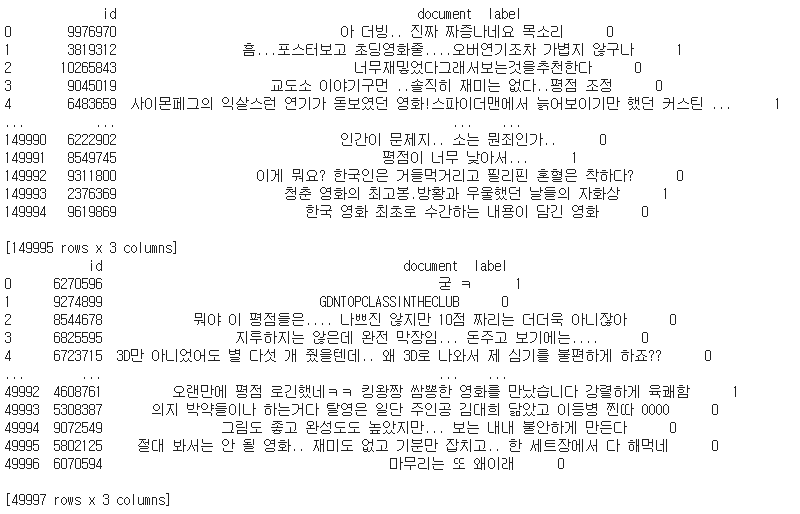

In [0]:
# max_len = 0
# a = -1
# for s in train_data['document']:
#     a += 1
#     if a %1000 == 0:
#         print(a)
#     token = tokenizer.tokenize(s)
#     max_len = max(max_len, len(token))

# print(max_len)

In [0]:
tokenizer = tokenization.FullTokenizer("/content/gdrive/My Drive/ML/HanBert-54kN/vocab_54k.txt", use_moran=True)

cls_token_id = 3
sep_token_id = 4
MAX_SEQUENCE_LENGTH = 140

train_inputs = compute_inputs(train_data, tokenizer, MAX_SEQUENCE_LENGTH)
train_outputs = compute_outputs(train_data)
test_inputs = compute_inputs(test_data, tokenizer, MAX_SEQUENCE_LENGTH)
test_outputs = compute_outputs(test_data)

In [0]:
# train_inputs,train_outputs,test_inputs,test_outputs

In [0]:
def create_model():
    ids = tf.keras.layers.Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32)
    mask = tf.keras.layers.Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32)
    seg = tf.keras.layers.Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32)
    
    
    config = BertConfig.from_json_file('/content/gdrive/My Drive/ML/HanBert-54kN/bert_config.json')
    config.output_hidden_states = False
    bert_model = TFBertModel.from_pretrained('/content/gdrive/My Drive/HanBert-54kN-torch.tar/HanBert-54kN-torch', config=config, from_pt=True)
    # bert_model = TFBertModel.from_pretrained('/content/drive/My Drive/ML/HanBert-54kN/model.ckpt.index', config=config)

    # bert_model = hub.KerasLayer('/content/gdrive/My Drive/ML/HanBert-54kN', trainable=True)
    x = bert_model([ids, mask, seg])[0]

    
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.models.Model(inputs=[ids, mask, seg,], outputs=x)
    
    return model

In [0]:
gkf = GroupKFold(n_splits=5).split(X=train_data.document, groups=train_data.document)

history = []
for fold, (train_idx, valid_idx) in enumerate(gkf):
    if fold in [0, 2]:
        print(f"fold : {fold}")
        X_train = [train_inputs[i][train_idx] for i in range(len(train_inputs))]
        Y_train = train_outputs[train_idx]

        X_valid = [train_inputs[i][valid_idx] for i in range(len(train_inputs))]
        Y_valid = train_outputs[valid_idx]
        
        K.clear_session()
        model = create_model()
        optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
        model.compile(loss='binary_crossentropy', optimizer=optimizer,metrics=['accuracy'])
        # model.summary()
        history.append(model.fit(X_train,Y_train,
                                 validation_data=(X_valid, Y_valid),
                                 epochs=3, batch_size=64))
        
        model.save_weights(f'/content/gdrive/My Drive/ML/HanBert-54kN/tf_model_{fold}.h5')

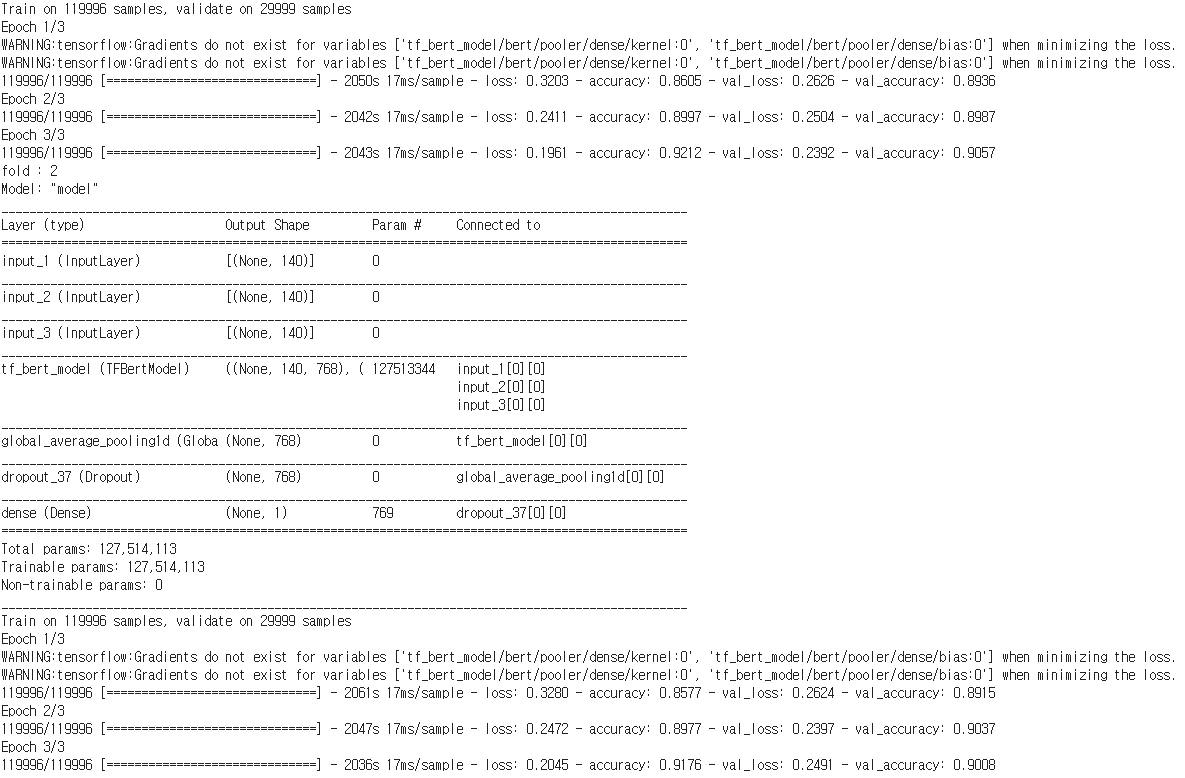

In [0]:
for i, h in enumerate(history):
    print(f'history : {i}')
    epochs = range(1, len(h.history['accuracy']) + 1)
    plt.plot(epochs, h.history['loss'])
    plt.plot(epochs, h.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

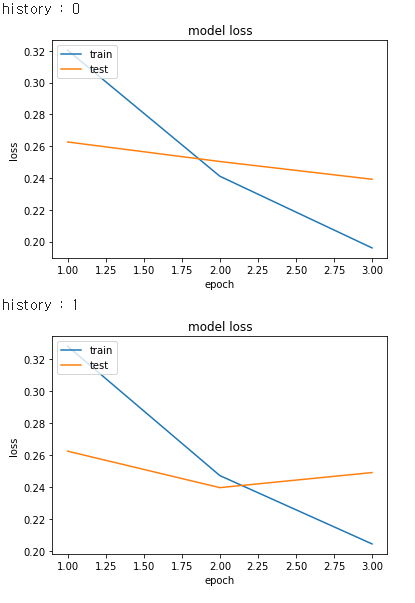

In [0]:
print("\n 테스트 정확도: %.4f" % (model.evaluate(test_inputs, test_outputs)[1]))

In [0]:
def create_model1():
    ids = tf.keras.layers.Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32)
    mask = tf.keras.layers.Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32)
    seg = tf.keras.layers.Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32)
    
    
    config = BertConfig.from_json_file('/content/drive/My Drive/ML/HanBert-54kN/bert_config.json')
    config.output_hidden_states = False
    bert_model = TFBertModel.from_pretrained('/content/drive/My Drive/ML/HanBert-54kN/tf_hub_model_0.h5', config=config)
    x = bert_model([ids, mask, seg])[0]

    
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.models.Model(inputs=[ids, mask, seg,], outputs=x)
    
    return model

load_model = create_model1()

print("\n 테스트 정확도: %.4f" % (model.evaluate(test_inputs, test_outputs)[1]))

49997/49997 [==============================] - 310s 6ms/sample - loss: 0.2580 - accuracy: 0.8986

 테스트 정확도: 0.8986
